# Exploratory Data Analysis

## Setup

In [1]:
import pandas as pd
import janitor
import os
import sys
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from eda_utils import add_gbp_columns, explode_lists
from stats_builder import make_summary_df, calculate_stats, make_calculated_df, format_stats, format_df
from plots_builder import make_bar_chart

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils import get_table_from_supabase

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

## Retrieving Data from Supabase and Building Dataframes

I will connect to Supabase and retrieve all records, in order to start building my analysis dataframes. I will create one dataframe for funder information, and another for grants and recipients information.

In [2]:
#get tables and build dataframes
tables = ["funders", "causes", "areas", "beneficiaries", "grants", "recipients",
               "funder_causes", "funder_areas", "funder_beneficiaries", "funder_grants", 
               "recipient_grants", "recipient_areas", "financials", "funder_financials"]

for table in tables:
    if table == "recipients":
        globals()[table] = get_table_from_supabase(url, key, table, batch_size=50, filter_recipients=True)
    else:
        globals()[table] = get_table_from_supabase(url, key, table)

print(f"Loaded {len(funders)} funders, {len(recipients)} recipients, {len(grants)} grants")

Loaded 502 funders, 524 recipients, 12867 grants


### The Funders Dataframe

#### Main Table

In [3]:
funders_df = funders.copy()

#define table relationships for funders
funder_rels = [
    {
        "join_table": funder_causes,
        "lookup_table": causes,
        "key": "cause_id",
        "value_col": "cause_name",
        "result_col": "causes"
    },
    {
        "join_table": funder_areas,
        "lookup_table": areas,
        "key": "area_id",
        "value_col": "area_name",
        "result_col": "areas"
    },
    {
        "join_table": funder_beneficiaries,
        "lookup_table": beneficiaries,
        "key": "ben_id",
        "value_col": "ben_name",
        "result_col": "beneficiaries"
    }
]

#group and merge
for rel in funder_rels:
    grouped = rel["join_table"].merge(rel["lookup_table"], on=rel["key"])
    grouped = grouped.groupby("registered_num")[rel["value_col"]].apply(list).reset_index()
    grouped.columns = ["registered_num", rel["result_col"]]
    funders_df = funders_df.merge(grouped, on="registered_num", how="left")

#add grant statistics columns 
grants_stats = funder_grants.merge(grants, on="grant_id")
grants_agg = grants_stats.groupby("registered_num").agg({
    "grant_id": "count",
    "amount": ["sum", "mean", "median"]
}).reset_index()
grants_agg.columns = ["registered_num", "num_grants", "total_given", "avg_grant", "median_grant"]

funders_df = funders_df.merge(grants_agg, on="registered_num", how="left")
funders_df["num_grants"] = funders_df["num_grants"].astype("Int64")

#replace nan values with empty lists
funders_df["causes"] = funders_df["causes"].apply(lambda x: x if isinstance(x, list) else [])
funders_df["areas"] = funders_df["areas"].apply(lambda x: x if isinstance(x, list) else [])
funders_df["beneficiaries"] = funders_df["beneficiaries"].apply(lambda x: x if isinstance(x, list) else [])

#round to 2 decimal places
funders_df = funders_df.round(2)
pd.set_option("display.float_format", "{:.2f}".format)

#format financial columns
float_cols = ["income_latest", "expenditure_latest", "total_given", "avg_grant", "median_grant"]
for col in float_cols:
    if col in funders_df.columns:
        funders_df[col + "_gbp"] = funders_df[col].apply(add_gbp_columns)

#### Financial History Table

In [4]:
#get full financial records and separate into income and expenditure
financial_history = funder_financials.merge(financials, on="financials_id")
income_history = financial_history[financial_history["financials_type"] == "income"]
expenditure_history = financial_history[financial_history["financials_type"] == "expenditure"]

#make financials dicts
income_by_funder = income_history.groupby("registered_num").apply(
    lambda x: dict(zip(x["financials_year"], x["financials_value"]))
).reset_index()
income_by_funder.columns = ["registered_num", "income_history"]

expenditure_by_funder = expenditure_history.groupby("registered_num").apply(
    lambda x: dict(zip(x["financials_year"], x["financials_value"]))
).reset_index()
expenditure_by_funder.columns = ["registered_num", "expenditure_history"]

#merge with funders and replace nans
funders_df = funders_df.merge(income_by_funder, on="registered_num", how="left")
funders_df = funders_df.merge(expenditure_by_funder, on="registered_num", how="left")
funders_df["income_history"] = funders_df["income_history"].apply(lambda x: x if isinstance(x, dict) else {})
funders_df["expenditure_history"] = funders_df["expenditure_history"].apply(lambda x: x if isinstance(x, dict) else {})

In [5]:
#extend column view, sort and preview funders
pd.set_option("display.max_columns", 100)
funders_df = funders_df.sort_values("total_given_gbp", ascending=False)
funders_df.head()

,registered_num,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_single_ben_funder,causes,areas,beneficiaries,num_grants,total_given,avg_grant,median_grant,income_latest_gbp,expenditure_latest_gbp,total_given_gbp,avg_grant_gbp,median_grant_gbp,income_history,expenditure_history
62,200051,Esmee Fairbairn Foundation,https://www.esmeefairbairn.org.uk,We are one of the largest independent foundati...,To further such charitable purpose or purposes...,9483000.00,56416000.00,AND ACTIVITIES VALUES OUR VALUES ACT AS A GUID...,None,None,False,"[General Charitable Purposes, Education/traini...","[Wigan, Oxfordshire, Greater Manchester]","[Children/young People, Elderly/old People, Pe...",6967,717939197.42,103048.54,54000.00,"£9,483,000.00","£56,416,000.00","£717,939,197.42","£103,048.54","£54,000.00",{},{}
164,294629,The Fenton Arts Trust,https://www.fentonartstrust.org.uk,Awards grants to individuals and organisations...,(a) the advancement of public education more p...,180898.00,178450.00,None,None,None,False,[Arts/culture/heritage/science],"[Warrington, Nottingham City, Oxfordshire, Lei...",[Other Defined Groups],175,663582.00,3791.90,4000.00,"£180,898.00","£178,450.00","£663,582.00","£3,791.90","£4,000.00",{},{}
492,274100,The Clothworkers' Foundation,https://clothworkersfoundation.org.uk,To make grants to uk frontline charities to su...,For the advancement of such charitable purpose...,12329000.00,12607000.00,None,None,None,False,[General Charitable Purposes],[],[Other Charities Or Voluntary Bodies],3237,66349023.60,20497.07,10000.00,"£12,329,000.00","£12,607,000.00","£66,349,023.60","£20,497.07","£10,000.00",{},{}
491,263207,John Ellerman Foundation,https://www.ellerman.org.uk,John ellerman foundation is a general grantmak...,1) the object of the charity is for such chari...,3431000.00,6239000.00,None,None,None,False,[General Charitable Purposes],[],[Other Charities Or Voluntary Bodies],764,65215922.90,85361.16,90000.00,"£3,431,000.00","£6,239,000.00","£65,215,922.90","£85,361.16","£90,000.00",{},{}
471,283813,The London Marathon Charitable Trust Limited,https://www.londonmarathonfoundation.org,"London marathon foundation, the operating name...",2.1 the charity's objects are restricted speci...,62715273.00,57810948.00,None,None,None,False,"[Disability, Amateur Sport, Human Rights/relig...",[],"[Children/young People, Elderly/old People, Pe...",775,62403416.00,80520.54,30000.00,"£62,715,273.00","£57,810,948.00","£62,403,416.00","£80,520.54","£30,000.00",{},{}


### The Grants Dataframe

#### Main Table

In [6]:
grants_df = grants.copy()

#add funder info
grants_df = grants_df.merge(funder_grants, on="grant_id")
grants_df = grants_df.merge(funders[["registered_num", "name"]], on="registered_num")
grants_df = grants_df.rename(columns={"name": "funder_name"})
grants_df = grants_df.rename(columns={"registered_num": "funder_num"})

#add recipient info  
grants_df = grants_df.merge(recipient_grants, on="grant_id")
grants_df = grants_df.merge(recipients[["recipient_id", "recipient_name", "recipient_activities"]], 
                        on="recipient_id", 
                        how="left")

#add recipient areas
recip_areas_grouped = recipient_areas.merge(areas, on="area_id")
recip_areas_grouped = recip_areas_grouped.groupby("recipient_id")["area_name"].apply(list).reset_index()
recip_areas_grouped.columns = ["recipient_id", "recipient_areas"]
grants_df = grants_df.merge(recip_areas_grouped, on="recipient_id", how="left")

#replace nan values with empty lists
if "recipient_areas" in grants_df.columns:
    grants_df["recipient_areas"] = grants_df["recipient_areas"].apply(lambda x: x if isinstance(x, list) else [])

#round to 2 decimal places
grants_df = grants_df.round(2)

#format financial columns
grants_df["amount_gbp"] = grants_df["amount"].apply(add_gbp_columns)

In [7]:
#sort and preview grants
grants_df = grants_df.sort_values("amount", ascending=False)
grants_df.head()

,grant_title,grant_desc,amount,year,grant_id,funder_num,funder_grants_id,funder_name,recipient_id,recipient_grants_id,recipient_name,recipient_activities,recipient_areas,amount_gbp
648,Grant To Museums Association,Towards delegated grant-making for the esmée f...,4178557.00,2019,360G-EFF-19-0186,200051,4891,Esmee Fairbairn Foundation,360G-EFF-001b000003VLsX5,3820,NaN,NaN,[],"£4,178,557.00"
790,Grant To Museums Association,Towards delegated grant-making towards the con...,3941914.00,2016,360G-EFF-15-2657,200051,6740,Esmee Fairbairn Foundation,360G-EFF-001b000003VLsX5,5669,NaN,NaN,[],"£3,941,914.00"
3449,Grant To Museums Association,Towards delegated grant-making towards the con...,3253420.00,2013,360G-EFF-13-0948,200051,9368,Esmee Fairbairn Foundation,360G-EFF-001b000003VLsX5,8297,NaN,NaN,[],"£3,253,420.00"
6816,Grant To Museums Association,Towards delegated grant-making to run the esme...,2720550.00,2024,360G-EFF-23-1758,200051,6454,Esmee Fairbairn Foundation,360G-EFF-001b000003VLsX5,5383,NaN,NaN,[],"£2,720,550.00"
5999,Grant To Museums Association,Towards delegated grant-making to develop a ne...,2683794.00,2022,360G-EFF-22-0530,200051,5624,Esmee Fairbairn Foundation,360G-EFF-001b000003VLsX5,4553,NaN,NaN,[],"£2,683,794.00"


## Summary Statistics

In [8]:
#build df of summary statistics
summary_data = make_summary_df(funders_df, grants_df)
summary_df = pd.DataFrame(summary_data)
summary_df["Value"] = summary_df.apply(format_stats, axis=1)
summary_df = format_df(summary_df)

Metric,Value
Total funders,502
Total recipients,"7,482"
Total grants,"12,813"
Total grant value,"£937,929,646.44"
Mean grants per funder,535
Most grants given by a funder,"6,967"
Fewest grants given by a funder,1
Mean recipients per funder,342.1
Mean areas per funder,5.8
Mean funder income,"£919,852.48"


## Calculated Statistics

In [9]:
#get calculated stats and build df
stats = calculate_stats(funders_df, grants_df)
calculated_data = make_calculated_df(stats)
calculated_df = pd.DataFrame(calculated_data)
calculated_df["Value"] = calculated_df.apply(format_stats, axis=1)
calculated_df = format_df(calculated_df)

Metric,Value
Share of grants from top 10% funders (by income),85.5%
Share of grants to top 10% recipients (by grant value),62.1%
Percent of recipients with multiple grants from same funder,27.8%
Average grants per funder-recipient pair,2
Mean grants-to-income ratio,191.5%
Median grants-to-income ratio,191.5%
Percent of funders supporting General Charitable Purposes only,0.0%


## Data Quality

### Missingness

#### 05/11
**`funders_df`:**
There are two funders in the database with empty `activities`. I have checked the Charity Commission website and it does appear that these funders have simply not declared any activities. They are both relatively new having submitted only one set of accounts. If the accounts are accessible to my script, the `activities_objectives` column will be populated and this issue will be redundant. One of these funders has a website so, if I am able to achieve my stretch target of scraping websites, this may be a further source of information (although at the time of writing, the website does not exist).

**`grants_df`:**
There are grants missing a title and description which is to be expected as they are pulled from accounts. There are grants missing recipient names which is fine as the database hasn't been built properly yet. There doesn't appear to be any missing data of concern.

**Accounts problem:**
My database_builder_pdfs scripts have a serious limitation as I am unable to scrape the Charity Commission website for accounts where the page contains JavaScript. The older pages, which are basic HTML, are accessible but the newer ones are not, and I am unable to tell which charities have been updated to the new system until the script attempts to scrape them and fails. I will calculate the proportion of accounts that are unavailable and will consider whether those funders should be excluded from the database.

In [10]:
funders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 62 to 501
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   registered_num            502 non-null    object 
 1   name                      502 non-null    object 
 2   website                   256 non-null    object 
 3   activities                500 non-null    object 
 4   objectives                502 non-null    object 
 5   income_latest             502 non-null    float64
 6   expenditure_latest        502 non-null    float64
 7   objectives_activities     10 non-null     object 
 8   achievements_performance  7 non-null      object 
 9   grant_policy              3 non-null      object 
 10  is_single_ben_funder      502 non-null    bool   
 11  causes                    502 non-null    object 
 12  areas                     502 non-null    object 
 13  beneficiaries             502 non-null    object 
 14  num_grants    

In [11]:
grants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13247 entries, 648 to 8366
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   grant_title           12655 non-null  object 
 1   grant_desc            12655 non-null  object 
 2   amount                13246 non-null  float64
 3   year                  13247 non-null  int64  
 4   grant_id              13247 non-null  object 
 5   funder_num            13247 non-null  object 
 6   funder_grants_id      13247 non-null  int64  
 7   funder_name           13247 non-null  object 
 8   recipient_id          13247 non-null  object 
 9   recipient_grants_id   13247 non-null  int64  
 10  recipient_name        715 non-null    object 
 11  recipient_activities  16 non-null     object 
 12  recipient_areas       13247 non-null  object 
 13  amount_gbp            13247 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 2.0+ MB


### Word Counts

I will check the lengths of the shortest and longest text entries, to ensure that they have been imported correctly and are not too short or long for unexpected reasons. Many funders provide very short explanations of their activities/objectives etc., such as simply "grant-giving" which is just one word - so this would not be abnormal. I will confirm that particularly long entries are not corrupted or the result of multiple documents being combined accidentally.

In [12]:
#check word counts for text columns in funders df
funders_text_cols = ["activities", "objectives", "objectives_activities", "achievements_performance", "grant_policy"]

#create columns
for col in funders_text_cols:
    funders_df[f"word_count_{col}"] = funders_df[col].str.split().str.len()
for col in funders_text_cols:
    print(f"{col.upper()}")
    print(f"{'_'*30}\n")

    word_count_col = f"word_count_{col}"
    not_nas = funders_df[funders_df[word_count_col].notna()]

    #get minimums and maximums for each text column
    if len(not_nas) > 0:
        min_idx = not_nas[word_count_col].idxmin()
        max_idx = not_nas[word_count_col].idxmax()

        examples = funders_df.loc[[min_idx, max_idx],
                                    ["registered_num", "name", word_count_col, col]]
        examples.index = ["Minimum", "Maximum"]

        display(examples)
    else:
        print("No data available\n")

ACTIVITIES
______________________________



,registered_num,name,word_count_activities,activities
Minimum,505515,ALLENDALE EXHIBITION ENDOWMENT,1.00,NONE
Maximum,298379,THE CARMELITE MONASTERY WARE TRUST,69.00,TO APPLY THE TRUST PROPERTY EITHER AS CAPITAL ...


OBJECTIVES
______________________________



,registered_num,name,word_count_objectives,objectives
Minimum,200566,MUNICIPAL CHARITIES,3,SEE INDIVIDUAL CONSTITUENTS
Maximum,1104413,Inspire Hounslow,524,"3. the objects of the company (the ""objects"") ..."


OBJECTIVES_ACTIVITIES
______________________________



,registered_num,name,word_count_objectives_activities,objectives_activities
Minimum,507021,HERBERT EDUCATIONAL FOUNDATION,85.00,TO PROMOTE AND SUPPORT EDUCATION OF PERSONS W...
Maximum,296688,SUFFOLK PROVINCIAL GRAND CHAPTER CHARITY,359.00,THE CHARITY'S OBJECTS ARE TO RAISE FUNDS AND T...


ACHIEVEMENTS_PERFORMANCE
______________________________



,registered_num,name,word_count_achievements_performance,achievements_performance
Minimum,507021,HERBERT EDUCATIONAL FOUNDATION,39.00,THE CHARITIES HAVE SUPPORTED THE SCHOOL WITH ...
Maximum,1029241,THE ASHFORD SCHOOL PARENTS AND FRIENDS ASSOCIA...,388.00,DURING THE YEAR THE PFA HAS MADE A SURPLUS OF...


GRANT_POLICY
______________________________



,registered_num,name,word_count_grant_policy,grant_policy
Minimum,1029241,THE ASHFORD SCHOOL PARENTS AND FRIENDS ASSOCIA...,8.00,POLICY ON SOCIAL INVESTMENT INCLUDING PROGRAM...
Maximum,507021,HERBERT EDUCATIONAL FOUNDATION,51.00,APPLICANTS APPLY IN WRITING FOR FINANCIAL SUP...


In [13]:
#check word counts for text columns in grants df
grants_text_cols = ["grant_title", "grant_desc", "recipient_activities"]

#create columns
for col in grants_text_cols:
    grants_df[f"word_count_{col}"] = grants_df[col].str.split().str.len()
for col in grants_text_cols:
    print(f"{col.upper()}")
    print(f"{'_'*30}\n")

    word_count_col = f"word_count_{col}"
    not_nas = grants_df[grants_df[word_count_col].notna()]

    #get minimums and maximums for each text column
    if len(not_nas) > 0:
        min_idx = not_nas[word_count_col].idxmin()
        max_idx = not_nas[word_count_col].idxmax()

        examples = grants_df.loc[[min_idx, max_idx],
                                    ["funder_num", "funder_name", "recipient_id", "recipient_name", word_count_col, col]]
        examples.index = ["Minimum", "Maximum"]

        display(examples)
    else:
        print("No data available\n")

GRANT_TITLE
______________________________



,funder_num,funder_name,recipient_id,recipient_name,word_count_grant_title,grant_title
Minimum,1093844,THE JOSEPH RANK TRUST,1086179,NaN,1.00,ALPHA
Maximum,263207,John Ellerman Foundation,360G-Ellerman-Org-9974,NaN,38.00,More In Common Will Provide Support For The Fo...


GRANT_DESC
______________________________



,funder_num,funder_name,recipient_id,recipient_name,word_count_grant_desc,grant_desc
Minimum,274100,The Clothworkers' Foundation,306075,NaN,1.00,0
Maximum,283813,The London Marathon Charitable Trust Limited,GB-LAE-BRY,NaN,100.00,"Towards delivering a making trax scheme, the c..."


RECIPIENT_ACTIVITIES
______________________________



,funder_num,funder_name,recipient_id,recipient_name,word_count_recipient_activities,recipient_activities
Minimum,1093844,THE JOSEPH RANK TRUST,250718,THE SANDES SOLDIERS' AND AIRMEN'S CENTRES',24.00,SANDES SOLDIERS' & AIRMEN'S CENTRES AS A CHRIS...
Maximum,1093844,THE JOSEPH RANK TRUST,1077512,HOYLAKE CHAPEL FELLOWSHIP TRUST,73.00,TO ADVANCE THE CHRISTIAN FAITH IN ACCORDANCE W...


Having manually checked the minimum and maximum values against their Charity Commission records, I am confident that there are no entries that are concerningly long. There do appear to be unusual values when it comes to looking at the minimum lengths (for example, a grant entitled simply 'ALPHA'), which I will scrutinise in more detail and then clean.

### Recipient Names

The `recipient_name` variable has been built from two sources. The first is the [Charity Commission's Public Extract](https://register-of-charities.charitycommission.gov.uk/en/register/full-register-download), which is updated daily and includes registered charities' names as logged with the Charity Commission. These names are generally clean and standardised, though charities occasionally use trading names that differ from their official registered names.

The second source is `recipient_name` as extracted from funders' accounts by the Claude API. This is significantly less reliable and is a noted limitation of this project. The reliability is affected in part by the reliance on a large language model and its fuzzy intepretations of messy text, but also due to the fact that funders' accounts are not held to any standard of enforcement in terms of the correct spelling, uniformity, or indeed accuracy of recipients' names. Examples that have been noted during the course of this project include variations on inclusion of "The" at the beginning of charity names (*The Society for...* vs *Society for...*); inconsistency in pluralisation (e.g. *hospices* vs *hospice*); and errors in punctuation (e.g. *soldiers'* vs *solider's*). The LLM has also at times failed to interpret account entries properly, extracting purchase descriptions as recipient names (e.g. 'cricket balls for the Year 7 team' from a PTA's accounts) or recording vague summaries as distinct recipients (e.g. 'five various causes'). These errors are particularly prevalent in accounts from single-beneficiary funders where expenditure descriptions differ structurally from multi-recipient grant listings.

Manual spot-checking is therefore essential to identify and address these inconsistencies.

## Exploration of Giving Patterns and Funder Characteristics

### Categorical Variables

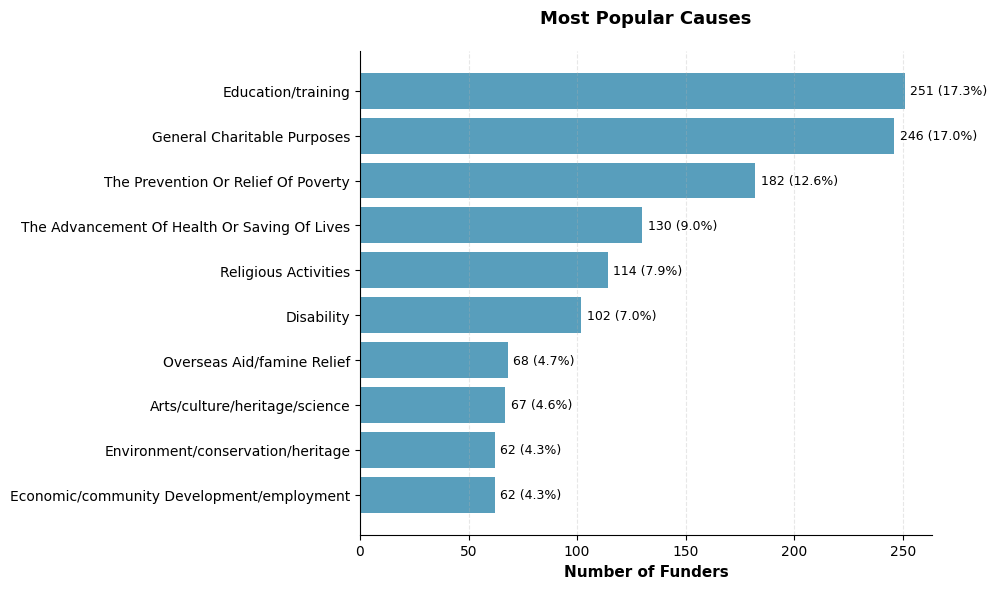

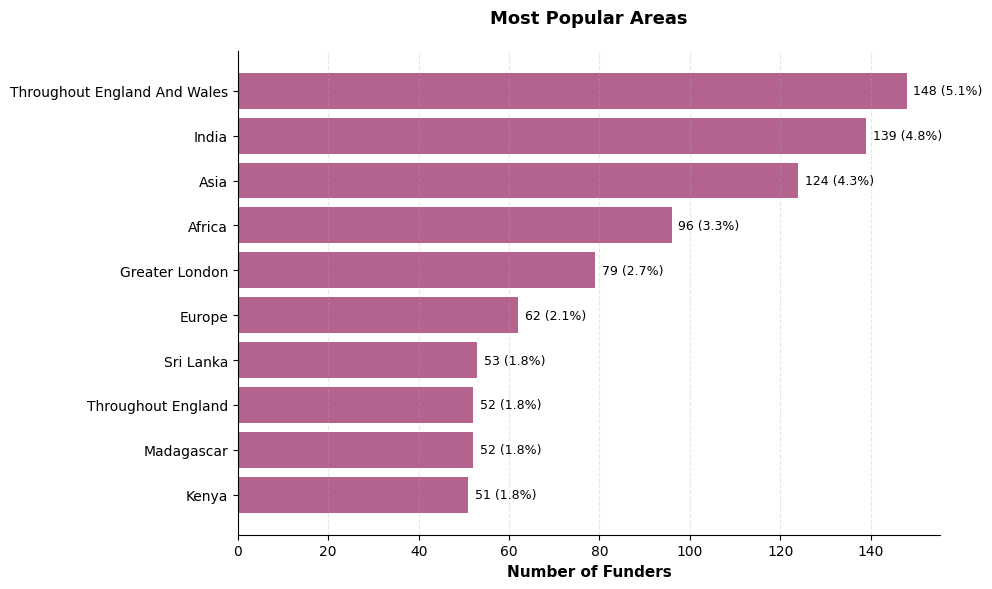

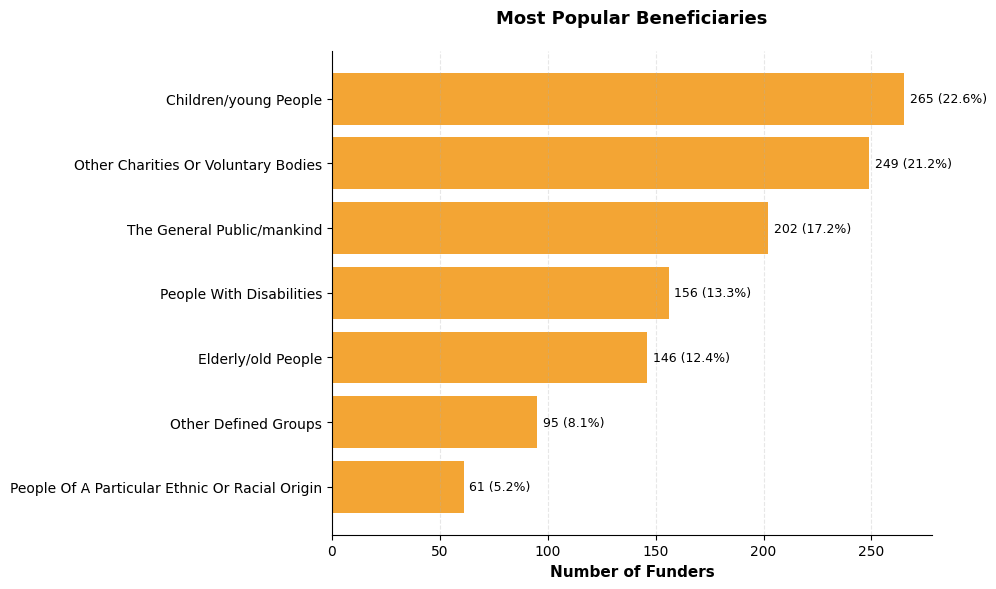

In [26]:
#display plots
make_bar_chart(funders_df, "causes", "Most Popular Causes", color="#2E86AB")
make_bar_chart(funders_df, "areas", "Most Popular Areas", color="#A23B72")
make_bar_chart(funders_df, "beneficiaries", "Most Popular Beneficiaries", color="#F18F01")

### Relationships between Categories